# Set up points in elite tennis

In [1]:
# import all necessary packages
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
from plotSlope import slope
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('data/pbp_matches_atp_main_archive.csv')
df.drop_duplicates(subset='pbp_id', keep="first", inplace=True)
df_short = df[['server1','server2','pbp','score']].copy()


In [3]:
df.head()

,pbp_id,date,tny_name,tour,draw,server1,server2,winner,pbp,score,adf_flag,wh_minutes
0,2231275,28 Jul 11,ATPStudenaCroatiaOpen-ATPUmag2011,ATP,Main,Olivier Rochus,Fabio Fognini,2,SSSS;RRRR;SSRRSS;SSRRSS;RSRSRSRR;SSRSS;RSRRSR;...,6-4 6-1,0,66
1,2231276,28 Jul 11,ATPStudenaCroatiaOpen-ATPUmag2011,ATP,Main,Robin Haase,Marin Cilic,2,SSRSS;RRSSRSSS;SSSS;RSSSS;SRSRSS;RSRSRSSS;RSRS...,4-6 6-4 6-3,0,141
2,2236280,29 Jul 11,ATPStudenaCroatiaOpen-ATPUmag2011,ATP,Main,Marin Cilic,Andreas Seppi,1,SSSS;SRRRR;SSRRRSSS;RSRRSSSS;RSRSSS;SRRRR;SSRS...,6-1 6-3,0,71
3,2233792,29 Jul 11,ATPStudenaCroatiaOpen-ATPUmag2011,ATP,Main,Alexandr Dolgopolov,Albert Ramos,1,SRSSRS;RRSSSRSS;RSRSSRSRSS;RRRR;SSRSS;SRSSS;SR...,6-3 7-5,0,83
4,2233791,29 Jul 11,ATPStudenaCroatiaOpen-ATPUmag2011,ATP,Main,Carlos Berlocq,Juan Carlos Ferrero,2,RRRR;SRSSS;SSRRSS;RSRSSS;RRRSR;SSSRRS;RRRR.SRR...,6-1 7-6(5),0,150


In [4]:
# set up helper functions
def isNoTiebreak(score):
    return not score.find("/") != -1

def getWinnerScore(score, game_number, isServer1 = True):
    ''' score: current game score in server-format: SSSR
        game_number: running number of game in match
        isServer1: if player started game as server
    '''
    if isServer1:
        if game_number % 2 == 0:
            tmp_score = score.replace('S','W').replace('R','L')
        else:
            tmp_score = score.replace('S','L').replace('R','W')
    else:
        if game_number % 2 == 0:
            tmp_score = score.replace('S','L').replace('R','W')
        else:
            tmp_score = score.replace('S','W').replace('R','L')
    return tmp_score
    

def get_server_scores(match_score,isServer1=True):
    ''' Returns list of points played per game in a match
        Flag: If player started the game as server    
    '''
    score_list = []
    match_score = match_score.replace('D','R').replace('A','S')
    
    scores = [set.split(";") for set in match_score.split(".")]
    game_number = 0 # Server1 starts match by definition
    for sets in scores:
        for game_score in sets:
            if isNoTiebreak(game_score):
                tmp_score= getWinnerScore(game_score, game_number, isServer1)
                score_list.append(tmp_score)
            game_number +=1
    return score_list

def calculatePoints(scoreString):
    hap_list = []
    for index in range(0,len(scoreString)):
        hap_list.append((scoreString[:index],scoreString[index:(index+1)]))
    return hap_list

def decode_score_string(score_str):
    own_score = score_str.count('W')
    opp_score = score_str.count('L')
    if own_score >= 3 and opp_score >= 3:
        if own_score - opp_score == 1:
            return "Ad:40"
        elif opp_score - own_score == 1:
            return "40:Ad"
        else:
            return "40:40"
    return "{}:{}".format(stringToScore[str(own_score)],stringToScore[str(opp_score)])



In [5]:
# test get_server_scores
# 6:3, 7:5
sample_match = 'SSSS;SSSRRS;SSSRRS;SSSRRS;SSSS;RSSSS;SSSRS;RRSSSRSRSRSRSS;SSSS;RRSSSS;SSRRSS;RRRR.SSSS;SSSRRRRR;SSSS;SSRSS;RSSSS;SSRSS;SSSS;SSSRS;RSSRSS'

correct_scores = [
    'WWWW',            # 0:     1:0, serve
    'LLLWWL',          # 1:     1:1, return
    'WWWLLW',          # 2:     2:1, server
    'LLLWWL',          # 3:     2:2, return
    'WWWW',            # 4:     3:2, server
    'WLLLL',           # 5:     3:3, return
    'WWWLW',           # 6:     4:3, server
    'WWLLLWLWLWLWLL',  # 7:     4:4, returner
    'WWWW',            # 8:     5:4, server
    'WWLLLL',          # 9:     5:5, returner
    'WWLLWW',          # 10:    6:5, server
    'WWWW',            # 11:    7:5, returner
    'WWWW',            # 12:    1:0, server
    'LLLWWWWW',        # 13:    2:0, returner
    'WWWW',            # 14:    3:0, server
    'LLWLL',           # 15:    3:1, returner
    'LWWWW',           # 16:    4:1, server
    'LLWLL',           # 17:    4:2, returner
    'WWWW',            # 18:    5:2, server
    'LLLWL',           # 19:    5:3, returner
    'LWWLWW'           # 20:    6:3, server
]

calculated_scores = get_server_scores(sample_match, isServer1=True)


assert(all(calculated == correct for calculated, correct in zip(calculated_scores,correct_scores)))

In [6]:
# get players with most played games
df1 = df[['server1','pbp']].groupby(['server1'])['pbp'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
df1.head(10)     

,server1,count
645,Tomas Berdych,244
140,David Ferrer,239
492,Novak Djokovic,239
322,John Isner,188
575,Roger Federer,188
558,Richard Gasquet,181
243,Grigor Dimitrov,178
408,Marin Cilic,160
317,Jo-Wilfried Tsonga,157
457,Mikhail Youzhny,145


In [7]:
stringToScore = {'0':'0','1': '15', '2':'30', '3':'40', '4':'Ad'}
possibleScores = ['0:0','15:0', '0:15', '0:30', '30:0','40:0','0:40','30:15','15:30','40:15','15:40','30:40','40:30','40:40', '30:30', '15:15','Ad:40','40:Ad']

OrderedColumns = ['0:0','0:15','15:0','15:15','0:30','30:15','30:0','15:30','40:15','15:40','30:40','40:30','30:30','40:40','Ad:40','40:Ad']
InitPoints = ['0:0','0:15','15:0','15:15']
SetupPoints = ['0:30','30:15','30:0','15:30','30:30','40:40'] # oder einstand eher zu ad points
AdPoints =  ['40:15','15:40','30:40','40:30','Ad:40','40:Ad']

columnNames = ['All points','InitPoints','HiddenAdPoints','AdPoints']
columnNamesSmallInit = ['All points','InitPoints']
columnNamesSmallHidden = ['All points','HiddenAdPoints']
columnNamesSmallAd = ['All points','AdPoints']


In [8]:
def f(df, isServer1=True):  
    scores_dict = defaultdict(list)
    
    for pbp in df['pbp'].values:
        scores_list = get_server_scores(pbp, isServer1=isServer1)
        pointScores = [calculatePoints(score) for score in scores_list]
        merged = list(itertools.chain.from_iterable(pointScores))
            
        score_dict = defaultdict(list)
        score_dict.update((k,[]) for k in possibleScores)

        for score, next_score in merged:
            decoded = decode_score_string(score)
            if decoded in score_dict.keys():
                score_dict[decoded].append(next_score)
  
        for k,v in score_dict.items():
            score_str = "".join(score_dict[k])
            if score_str:
                scores_dict[k].append(score_str.count('W')/len(score_str))
            else:
                scores_dict[k].append(None)

    for k,v in scores_dict.items():
        if k in score_dict.keys():
            df[k] = scores_dict[k]
                
    return df


In [9]:
aggdf = df_short.groupby('server1').filter(lambda x: len(x) > 160).groupby('server1').apply(lambda df: f(df, isServer1=False))

In [10]:
aggdf.head()

,server1,server2,pbp,score,30:15,30:0,40:15,0:15,40:Ad,30:40,...,40:0,15:40,40:30,15:15,15:0,0:40,0:0,30:30,40:40,Ad:40
59,Grigor Dimitrov,Tim Smyczek,SSRSS;RRSSSS;SSSS;SRSSS;SSSS;SSRRSRSS;RRSRR;RR...,4-6 7-6(3) 7-6(3),0.571429,0.142857,0.555556,0.388889,0.727273,0.363636,...,0.0,0.600000,0.583333,0.500000,0.437500,0.666667,0.470588,0.615385,0.476190,0.60
63,John Isner,Tobias Kamke,RRSSRSSS;RSSSS;RSSSS;RRRSSSRR;SSRSS;RRSRR;RSRR...,6-1 6-3,0.333333,0.000000,0.500000,0.222222,0.333333,0.600000,...,NaN,0.428571,0.500000,0.625000,0.142857,0.500000,0.437500,0.600000,0.142857,1.00
84,Richard Gasquet,Florian Mayer,SSSS;RRSRR;SRSRSS;SSRSS;RSSRSRSRSRSS;SSRSS;SSR...,6-3 6-2,0.714286,0.000000,0.600000,0.300000,0.400000,0.333333,...,NaN,0.500000,0.333333,0.571429,0.428571,0.250000,0.411765,0.200000,0.285714,0.50
91,Tomas Berdych,Alexandr Dolgopolov,RRRR;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;S...,4-6 6-2 6-3,0.250000,0.769231,0.000000,0.166667,0.000000,0.200000,...,1.0,NaN,0.000000,0.250000,0.866667,0.000000,0.555556,0.166667,0.333333,1.00
92,Roger Federer,Vasek Pospisil,SSSS;SSSRRS;SSSRRS;SSSRRS;SSSS;RSSSS;SSSRS;RRS...,7-5 6-3,1.000000,0.666667,0.571429,0.076923,0.000000,0.000000,...,0.0,0.333333,0.600000,0.333333,0.750000,0.222222,0.380952,0.500000,0.800000,0.25


In [11]:
def getPointData(data, player='Roger Federer', pointtype='all'):
    # pointtype: 'all', 'init', 'setup', 'ad'
    columns = data.columns.tolist()
    if pointtype == 'init':
        columns = InitPoints
    elif pointtype == 'setup':
        columns = SetupPoints
    elif pointtype == 'ad':
        columns = AdPoints
    else:
        columns = OrderedColumns
    #return data[data['server1']==player].groupby('server1').apply(f)[columns]
    return pd.concat([data[data['server1']==player].groupby('server1').apply(f)[columns],data[data['server2']==player].groupby('server2').apply(lambda df: f(df, isServer1=False))])

In [14]:
len(getPointData(df_short, player='Tomas Berdych', pointtype='all'))

314

In [15]:
len(df_short[(df_short['server1']=='Tomas Berdych') | (df_short['server2']=='Tomas Berdych')])

314

In [16]:
aggdf.loc[91].pbp

'RRRR;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS;SSSS.RRRR;RRRR;SSSS;RRRR;SSSS;SSSS;SSSS;RRRR.RSSRSS;SSSS;SRSRSRSS;SSSS;SRRSSS;SSRRRR;RSSRSS;SSRSRRSS;RRSSRSSS'

In [17]:
getPointData(df_short, player='Tomas Berdych', pointtype='init').mean().mean()

0.5151641584469105

In [12]:
def getAllWinPercentages(data, player='Roger Federer'):
    init = getPointData(df_short, player=player, pointtype='init').mean().mean()
    setup = getPointData(df_short, player=player, pointtype='setup').mean().mean()
    ad = getPointData(df_short, player=player, pointtype='ad').mean().mean()
    all = getPointData(df_short, player=player, pointtype='all').mean().mean()
    return init, setup, ad, all

In [13]:
getAllWinPercentages(df_short)

(0.536450265587221, 0.538056847418827, 0.5390781574493289, 0.5396997731491031)

In [14]:
groupList = ['Andy Murray',
 'Jo-Wilfried Tsonga',
 'Novak Djokovic',
 'Rafael Nadal',
 'Roger Federer',
 'Stan Wawrinka',
 'Tomas Berdych',
 'Fabio Fognini',
 'John Isner']

grouped = df_short.groupby('server1')
new_gb = pd.concat( [ grouped.get_group(group) for group in groupList] )    
new_gb.head()

,server1,server2,pbp,score
121,Andy Murray,David Nalbandian,RRRSR;RRSRSSRSSRRSRSSRSS;SSSRS;SRRRSSSS;SSSS;S...,6-4 6-1
128,Andy Murray,Mardy Fish,SRSSS;RSSSS;SSRRSRSS;RRSRSSRSRSSRRR;RSSRRSSS;S...,6-3 7-6(8)
190,Andy Murray,Somdev Devvarman,RRRSSSSRRR;SRRSSRSRSS;SSSS;SSRSRRRSSS;SSSS;SRS...,7-6(5) 6-2 6-3
259,Andy Murray,Gyorgy Balazs,SSSS;SSSS;SSSS;SSSS;SSSRRS;SSSRS;SSSRRS;SSSS;R...,7-6(3) 6-3
269,Andy Murray,Rafael Nadal,RRSSSS;RSSSS;RRSSSRSRRSSS;SSSS;SSSS;RSRSRSSRSR...,6-4 6-2 3-6 6-2


In [15]:
def getPointDataForPlayers(data, players=['Roger Federer'], rename=False, server=True):
    serverFlag = 'server1' if server else 'server2'
    grouped_data = data.groupby(serverFlag)

    temp_df = pd.concat( [ grouped_data.get_group(player) for player in players] )   
    init = temp_df.groupby(serverFlag).apply(f,isServer1=server).groupby(serverFlag)[InitPoints].mean().mean(axis=1)
    setup = temp_df.groupby(serverFlag).apply(f,isServer1=server).groupby(serverFlag)[SetupPoints].mean().mean(axis=1)
    ad = temp_df.groupby(serverFlag).apply(f,isServer1=server).groupby(serverFlag)[AdPoints].mean().mean(axis=1)
    all = temp_df.groupby(serverFlag).apply(f,isServer1=server).groupby(serverFlag)[OrderedColumns].mean().mean(axis=1)
    new_df = pd.concat([init, setup, ad, all], axis=1)
    if rename == True:
        new_df.columns=['init points','set-up points','ad points','all points'] 
        
    return new_df

In [16]:
def getWinrateForPoints(data, players=['Roger Federer'], rename=False):
    df_srv = getPointDataForPlayers(data,players=players, rename=rename, server=True)#.reset_index()
    df_srv = df_srv.rename(columns = {'server1':'server'})
    df_rcv = getPointDataForPlayers(data,players=players, rename=rename, server=False)#.reset_index()
    df_rcv = df_rcv.rename(columns = {'server2':'server'})
    return df_srv.add(df_rcv)/2

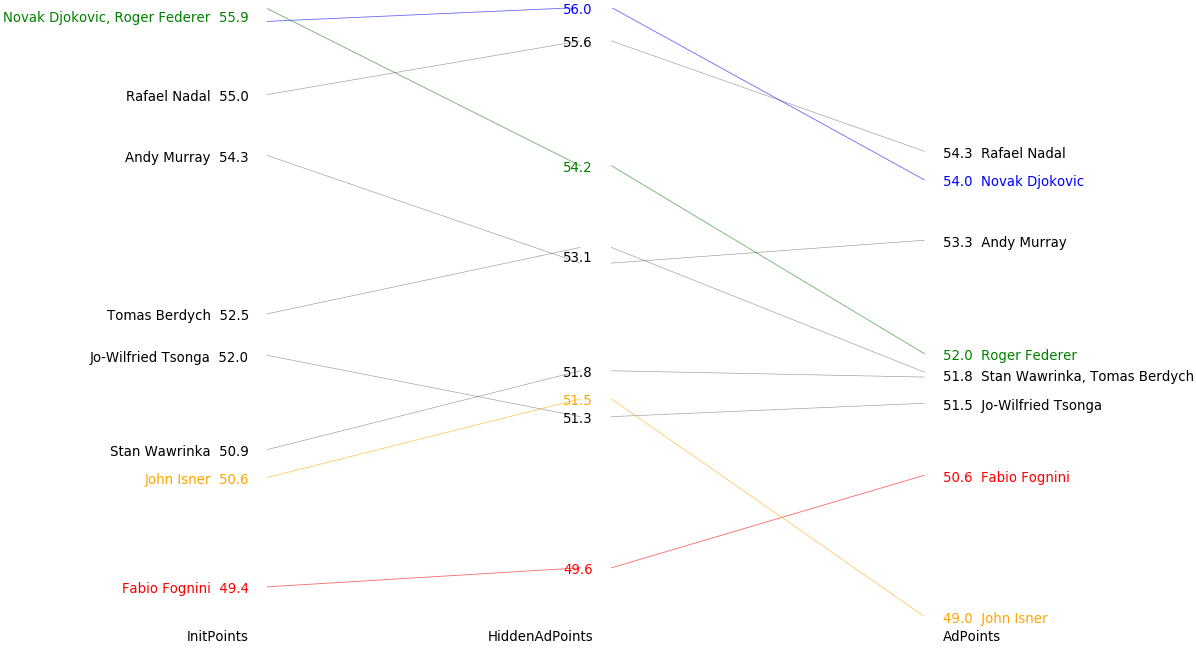

In [17]:
point_data = getWinrateForPoints(df_short,players=groupList)
point_data.drop(3,axis=1,inplace=True)
color={'Roger Federer':'green','Novak Djokovic':'blue','Fabio Fognini':'red','John Isner':'orange'}
fig = slope(point_data*100,kind='interval',columnNames = columnNames[1:], marker='%2.1f',font_family='DejaVu Sans',color=color,height= 22,width=40,font_size=32,dpi=150,savename=None)


In [18]:
test_df = getWinrateForPoints(df_short,players=groupList)
test_df.columns=['init points','set-up points','ad points','all points']
test_df

,init points,set-up points,ad points,all points
server1,,,,
Andy Murray,0.542770,0.530526,0.533124,0.534562
Fabio Fognini,0.493702,0.495867,0.506395,0.499274
Jo-Wilfried Tsonga,0.520035,0.513061,0.514583,0.515375
John Isner,0.506141,0.515070,0.490332,0.503561
Novak Djokovic,0.558021,0.559598,0.539994,0.551852
Rafael Nadal,0.549699,0.555793,0.543248,0.549565
Roger Federer,0.559469,0.541602,0.520223,0.538051
Stan Wawrinka,0.509315,0.518279,0.517562,0.515769
Tomas Berdych,0.524757,0.532310,0.518125,0.525103


In [132]:
test_df.sort_values('set-up points', ascending=False)

,init points,set-up points,ad points,all points
server1,,,,
Novak Djokovic,0.558021,0.559598,0.539994,0.551852
Rafael Nadal,0.549699,0.555793,0.543248,0.549565
Roger Federer,0.559469,0.541602,0.520223,0.538051
Tomas Berdych,0.524757,0.532310,0.518125,0.525103
Andy Murray,0.542770,0.530526,0.533124,0.534562
Stan Wawrinka,0.509315,0.518279,0.517562,0.515769
John Isner,0.506141,0.515070,0.490332,0.503561
Jo-Wilfried Tsonga,0.520035,0.513061,0.514583,0.515375
Fabio Fognini,0.493702,0.495867,0.506395,0.499274


In [131]:
test_df.sub(test_df['all points'], axis=0).sort_values('ad points', ascending=False)

,init points,set-up points,ad points,all points
server1,,,,
Andy Murray,0.008209,-0.004035,-0.001437,0.0
Fabio Fognini,-0.005572,-0.003407,0.007122,0.0
Jo-Wilfried Tsonga,0.004660,-0.002314,-0.000793,0.0
John Isner,0.002580,0.011509,-0.013229,0.0
Novak Djokovic,0.006168,0.007746,-0.011858,0.0
Rafael Nadal,0.000134,0.006228,-0.006317,0.0
Roger Federer,0.021417,0.003550,-0.017828,0.0
Stan Wawrinka,-0.006454,0.002510,0.001793,0.0
Tomas Berdych,-0.000345,0.007208,-0.006978,0.0


# A short study of hidden ad points in tennis

<blockquote>
Recreational tennis players tend to consider most points and games in their match as being roughly equivalent. The second point of a game is about the same as the fourth point, 15-15 is no different from 30-30.[...] There are certain moments in the match that are dynamic and volatile. They have both psychological and strategic weight that can really help or hurt your cause.
</blockquote>
<p>Excerpt from <cite>Winning Ugly</cite> by Brad Gilbert. Published in 1993.</p>

I could not find any research about this important concept. When working on my data incubator capstone project I've recognized that Jeff Sackmann also has gathered sequential point-by-point data for tens of thousands of pro matches from ATP Tour, WTA Tour and ITF tournaments <a href="https://github.com/JeffSackmann">[Github repo]</a>. The dataset I used consists of point-by-point data of almost 11 000 matches played at the ATP World Tour between 28.7.2011 and 20.12.2015. The idea is to use these data to check if there is a difference how top players play these Set-up points compared to "average" players. 

If Brad Gilbert is right, the top players should have a higher winrate at Set-up points than at ad points. I spare you the details about the data analysis in Python. For this I break down individual points into three categories:
* initial points (0-0, 0-15, 15-0, 15-15),  
* set-up points (0-30, 30-0, 15-30, 30-15, 30-30 and 40-40), 
* ad points (40-0, 40-15, 40-30, 0-40, 15-40, 30-40, Ad-40 and 40-Ad), 

and compute the win rate of each ATP Tour player. 

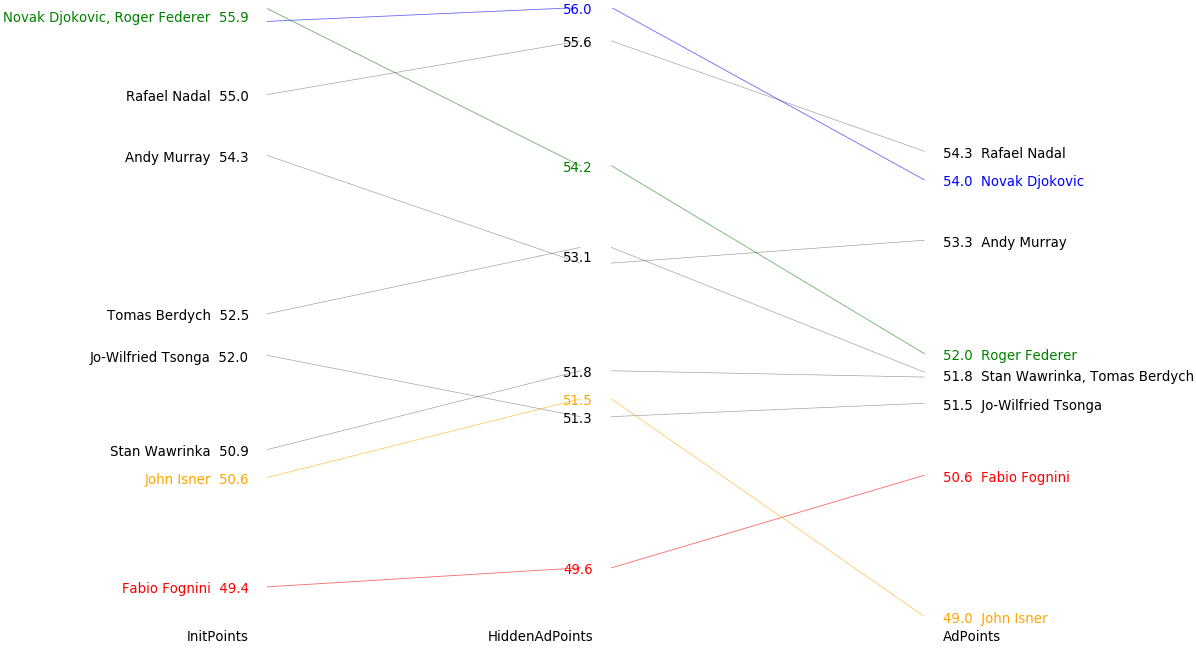

In [19]:
point_data = getWinrateForPoints(df_short,players=groupList)
point_data.drop(3,axis=1,inplace=True)
color={'Roger Federer':'green','Novak Djokovic':'blue','Fabio Fognini':'red','John Isner':'orange'}
fig = slope(point_data*100,kind='interval',columnNames = columnNames[1:], marker='%2.1f',font_family='DejaVu Sans',color=color,height= 22,width=40,font_size=32,dpi=150,savename=None)


I've visualized the result using a [slope graph](http://charliepark.org/slopegraphs/) to be able to easily identify trends and similarities for a large number of players. The horizontal axis shows the initial points, set-up points and ad points and the vertical axis depicts the winning probability of each player for each of these points. The values of each player are connected by a line and its slope easily tells us if there is a positive or negative trend between the winning percentages.
Plotting some of the best players between 2011 and 2015 shows that these players win set-up points more often than ad points which makes sense following the discussion by Brad Gilbert. But surprisingly the good players win even more often when they play the first points in a game. 
Also interestingly John Isner, highlighted in orange, seems to play the exact same game at each point and Fabio Fognini is especially good at ad points (or poor at all other points).

As a short disclaimer, I have just started my investigation of the data and therefore any conclusion might be terribly wrong. 